# Imports

In [13]:
import requests
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm_notebook as tqdm 
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import itertools



# Web Scraping

## Constructing the links for keywords

In [3]:
#I want to find information about jobs ads that are associated with the following keywords. I focus on the Swiss market
#and in particular I will use data scraped from the jobs.ch.
keywords=["Data Scientist", "Data Analyst", "Python Developer", "Data Engineer", "Data Manager", "Data Architect", "Big Data Analyst", "Data Python"]

### Get the max pages and link for keyword and second part of the link (the part refering to the keyword)

In [4]:
link_first_part = 'https://www.jobs.ch'
link_mid_1_part = '/en/vacancies/?page='
link_mid_2_part = '&term='



def find_keyword_page(keyword):
    #take a keyword and output the link to the first page containing that keyword and the number of pages with that keyword
    
    url= link_mid_2_part + keyword.replace(' ', '%20') #part1:create final part url
    
    response = requests.get(link_first_part + link_mid_1_part + '1'+url, timeout = 15)    #part2: check how many pages are associated with keyword
    soup = BeautifulSoup(response.content, 'html.parser')
    max_pages = int(soup.find('div', class_ = 'Box-sc-7ekkso-0 Text-n7n7hk-0 gLTudq').get_text().split()[2])
   
    
    return url, max_pages 

In [5]:
#example function
dat, max_p=find_keyword_page(keywords[5])
print (dat, max_p)

&term=Data%20Architect 12


## Get the links
### Get the job links for one page

In [6]:
link_first_part = 'https://www.jobs.ch'
link_mid_1_part = '/en/vacancies/?page='

def get_links(link, job_links):
    
    response = requests.get(link, timeout = 15)
    soup = BeautifulSoup(response.content, 'html.parser')
    job_link_content = soup.find_all('div', class_ = 'Box-sc-7ekkso-0 Position-b2pct5-0 Position__Relative-b2pct5-1 VacancySerpItemDetail__ShadowBox-sc-1v08377-0 dyOJLL')
    
    for job_link in job_link_content:
         job_links.append(link_first_part + job_link.find('a', {'class': 'x--job-link t--job-link SearchVacancyResultsComponent__StyledVacancySerpItem-xx0iax-0 pvidX'}).get('href'))    

    return job_links
    

### Create a dictionary with key=keyword and a list of the links referring to that keyword

In [7]:
dic={}

for keyword in tqdm(keywords): #I loop over all the categories' key
    
    url, max_pages = find_keyword_page(keyword) #for each category key I find the link for that category and how many pages 
    job_links = []

        
    for page in range(max_pages): #I loop over all the pages resulting from a specific keyword
        
        link = link_first_part + link_mid_1_part + str(page+1) + url
        get_links(link, job_links) 
        
        sleep(0.6)
    
    dic[keyword]=job_links #I store the links in a dictionary 
    
    print(len(dic[keyword]), "++++++", dic[keyword][0:2])

KeyboardInterrupt: 

## Get the page's content

In [8]:
# grab info from the correct tags
def scrape_content(soup):
    try:
        job_title = soup.find('h1', class_ = 'e-heading vacancy-ad-title h-base x--vacancy-title').get_text()
    except:
        job_title = np.nan
        
    try:
        company_name = soup.find('div', class_ = 'vacancy-ad-company x--vacancy-ad-company').find('span').get_text()
    except:
        company_name = np.nan

    try:
        job_location = soup.find('span', class_ = 'svg-icon icon icon-location').next_sibling
    except:
        job_location = np.nan
        
    try:
        company_type = soup.find('span', class_ = 'svg-icon icon icon-case').next_sibling
    except:
        company_type = np.nan
        
    try:
        job_rank = soup.find('span', class_ = 'svg-icon icon icon-rank').next_sibling
    except:
        job_rank = np.nan

    try:
        job_content = soup.find('div', class_ = 'container vacancy-detail-content').get_text()
    except:
        job_content = np.nan
    
    return job_title, company_name, job_location, company_type, job_rank, job_content



## Scrape the job ads
### Create a pandas dataframe with the information I want

In [494]:
columns = [
    'Keywords searched',
    'Link',
    'Job title',
    'Date parsed',
    'Company name',
    'Location',
    'Company type',
    'Job rank',
    'Content',
]

df = pd.DataFrame(columns = columns)
df

,Keywords searched,Link,Job title,Date parsed,Company name,Location,Company type,Job rank,Content


In [62]:
for keyword in tqdm(keywords): #I loop on keywords
    
    for job_ad in tqdm(dic[keyword]): #for every keyword I access through the dictionary to the link for jobs for that keyword
    
        response = requests.get(job_ad, timeout = 15)
        soup = BeautifulSoup(response.content, 'html.parser')
    
         #scrape the content
        job_title, company_name, job_location, company_type, job_rank, job_content = scrape_content(soup)
    
         # we append the data to the dataframe
        df = df.append({
        'Keywords searched': keyword,
        'Link':job_ad,
        'Job title': job_title,
        'Date parsed': datetime.now().date(),
        'Company name': company_name,
        'Location': job_location,
        'Company type': company_type,
        'Job rank': job_rank,
        'Content': job_content}, ignore_index = True
        )
        sleep(0.62)
        

In [9]:
# save the dataframe to a csv file without the index
df.to_csv('jobs_dataset.csv', index=False)

NameError: name 'df' is not defined

# Analysis of the data we collected

### cleaning and exploring


In [14]:
df=pd.read_csv('jobs_dataset.csv')
df.shape

(4840, 9)

In [15]:
#len(df)-len(df.drop_duplicates()) #check how many duplicates there are

In [16]:
df_wd=df.drop_duplicates() #dropping duplicates
df_wd.shape

(4512, 9)

In [17]:
#I realized that two different links can point to the same position ---> not a good way to filter. There might still be duplicate
#I will use the other variables to get rid of the duplicates. Specially the Content will be indicative

In [18]:
df_wd=df_wd.drop_duplicates(["Keywords searched","Content","Company name","Location","Company type","Job rank"])
df_wd.shape

(4423, 9)

## 1. Jobs in all categories

In [19]:
#I want to check which job (characterized by a unique["Company name","Content","Location","Company type"]
#is shared by multiple "Keywords searched" ---> I group by unique job and count how many entries(one for each keyword)
#are in my dataframe
unique_job=["Company name","Content","Location","Company type"]
df_jc=df_wd.groupby(unique_job).count().sort_values(["Keywords searched"],ascending=False)

In [20]:
# I can plot my result for better visualization
df_jc=df_jc.groupby("Keywords searched").count().sort_values("Keywords searched",ascending=False)


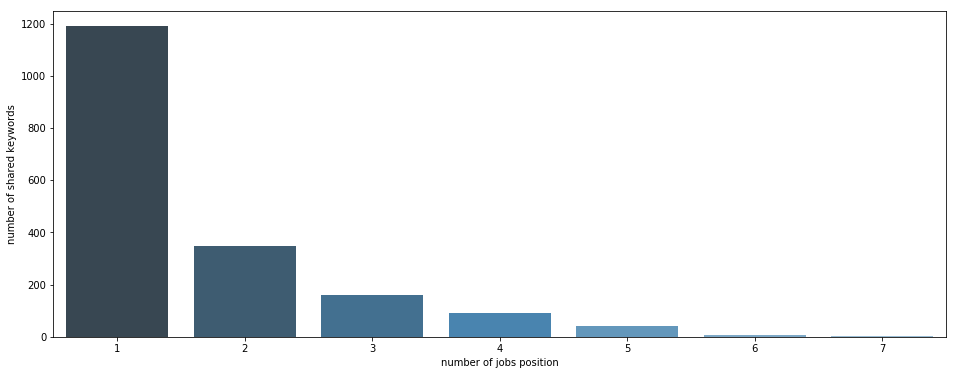

In [21]:
plt.figure(figsize=(16, 6))

ax= sns.barplot(x=df_jc.index, y=df_jc["Job title"],  palette="Blues_d")
ax.set(xlabel='number of jobs position', ylabel='number of shared keywords')
plt.show()

## 2 Jobs shared in 2 categories

In [22]:
#example with two specific keywords Data Scientist Data Analyst
df_dsda=df_wd[(df_wd['Keywords searched']=="Data Scientist") | (df_wd['Keywords searched'] == "Data Analyst")]

In [23]:
ds=df_dsda.groupby(unique_job).count().sort_values(["Keywords searched"],ascending=False).groupby("Keywords searched").count().sort_values("Keywords searched",ascending=False)
#ds

In [24]:
#create all possible couples of keywords
keywords=["Data Scientist", "Data Analyst", "Python Developer", "Data Engineer", "Data Manager", "Data Architect", "Big Data Analyst", "Data Python"]
all_couples=list(itertools.combinations(keywords, 2))
all_couples[0:3]

[('Data Scientist', 'Data Analyst'),
 ('Data Scientist', 'Python Developer'),
 ('Data Scientist', 'Data Engineer')]

In [26]:
# Matrix initialization
corr_mat=np.zeros((8,8))
count=0
count_r=0

In [27]:
for couple in all_couples:
    
    #I use the same idea of before --->group by unique jobs and count after. Now the difference is that the starting
    #dataframe is filtered in such a way that only two keywords of interest at the time are considered.
    df_mix=df_wd[(df_wd['Keywords searched']==couple[0]) | (df_wd['Keywords searched'] == couple[1])]
    ds=df_mix.groupby(unique_job).count().sort_values(["Keywords searched"],ascending=False).groupby("Keywords searched").count().sort_values("Keywords searched",ascending=False)
    
    #I store everything in a sort of correlation matrix
    corr_mat[count_r,count+1]=ds.iloc[0][1]/(2*ds.iloc[0][1]+ds.iloc[1][1])  #this is the proportion of job offers
                                                                                 #that appears using the key word on the 
    count=count+1                                                                #respective row-column with over the
    if count==7:                                                                 #total number of offers that have at least
        count_r+=1                                                               #one of the two
        count=count_r
        
        
    
    

In [28]:
corr_mat=np.around(corr_mat, decimals=2)
corr_mat=np.add(corr_mat,np.transpose(corr_mat)+np.identity(8))

In [30]:
df_hm = pd.DataFrame(corr_mat,index=keywords, columns=keywords)
#df_hm

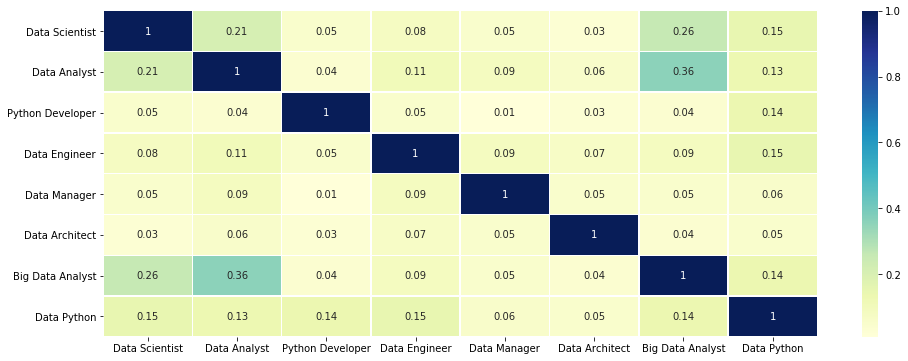

In [31]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(df_hm, annot=True, linewidth=0.5, cmap="YlGnBu")
plt.show()

## 3 Are there some companies doing more hires than average?

In [32]:
#In order to count twice same jobs with different keywords I will first drop them from the dataframe
df_comp=df_wd.drop_duplicates(unique_job)

In [33]:
df_wd.shape

(4423, 9)

In [34]:
df_wd.drop_duplicates(unique_job)

,Keywords searched,Link,Job title,Date parsed,Company name,Location,Company type,Job rank,Content
0,Data Scientist,https://www.jobs.ch/en/vacancies/detail/916705...,Leiter Analytik und Qualitätskontrolle (m/w),2019-09-07,Batterman Consulting Basel AG,Muttenz,Consultants,Executive po­si­tion,Leiter Analytik und Qualitätskontrolle (m/w)Le...
1,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918366...,Associate Scientist,2019-09-07,Harvey Nash AG,Basel,Consultants,Employee,Associate ScientistFor our client in Basel we ...
2,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918778...,Junior Data Analyst (m/w),2019-09-07,Coop Genossenschaft,Basel,Large-scale entreprises,Employee,"Coop hat den Anspruch, die beste und kundennäc..."
3,Data Scientist,https://www.jobs.ch/en/vacancies/detail/868930...,Senior Data Scientist - Forensics in Zurich,2019-09-07,EY,"Zurich, CH-ZH",Large-scale entreprises,Employee,Senior Data Scientist - Forensics in ZurichWe ...
4,Data Scientist,https://www.jobs.ch/en/vacancies/detail/919588...,Data Analyst,2019-09-07,Kelly Scientific Resources Zürich,Graubünden,Consultants,Employee,Data Analyst Unser Kunde ist ein Unternehmen i...
5,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918819...,Data Analyst (Master Data Management) (m/w),2019-09-07,SBB AG,Bern/ Work Smart,Large-scale entreprises,Position with re­spon­si­bil­i­ties,Bern/ Work SmartData Analyst (Master Data Mana...
6,Data Scientist,https://www.jobs.ch/en/vacancies/detail/915880...,Specialist Credit & Fraud Risk / Data Analytics,2019-09-07,Swisscard AECS GmbH,Horgen,Large-scale entreprises,Position with re­spon­si­bil­i­ties,Specialist Credit & Fraud Risk / Data Analytic...
7,Data Scientist,https://www.jobs.ch/en/vacancies/detail/919846...,Data Analyst/in und Applikations Verantwortlic...,2019-09-07,SBB AG,Bern/ Work Smart,Large-scale entreprises,Position with re­spon­si­bil­i­ties,Bern/ Work SmartData Analyst/in und Applikatio...
8,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918043...,Fachspezialist Messdaten (m/w),2019-09-07,BKW Energie AG,Nidau,Large-scale entreprises,Employee,Sie arbeiten aktiv bei der Weiterentwicklung ...
9,Data Scientist,https://www.jobs.ch/en/vacancies/detail/915477...,Engineer Data Analytics (m/w),2019-09-07,dasteam ag,"Thurgau, Basel oder Bern",Consultants,Employee,"Unser Kunde, mit Hauptsitz im Thurgau, ist ein..."


In [35]:
df_comp=df_wd.drop_duplicates(unique_job)

In [36]:
df_comp.shape

(2744, 9)

In [37]:
df_comp=df_comp.groupby("Company name").count().sort_values("Job title",ascending=False)
df_comp.head()

print("there are in total",len(df_comp),"firms. They post an average", df_comp["Job title"].mean(), "positions") 

there are in total 875 firms. They post an average 3.1165714285714285 positions


In [41]:
above_average=df_comp[df_comp["Job title"]>df_comp["Job title"].mean()]
print(len(above_average), "hire more than average,", len(df_comp)-len(above_average), "below average.")

193 hire more than average, 682 below average.


In [42]:
df_comp[df_comp["Job title"]>df_comp["Job title"].mean()][0:10]

,Keywords searched,Link,Job title,Date parsed,Location,Company type,Job rank,Content
Company name,,,,,,,,
Credit Suisse AG,105,105,105,105,105,105,105,105
F. Hoffmann-La Roche AG,91,91,91,91,91,91,91,91
UBS AG,70,70,70,70,70,4,70,70
Swisscom (Schweiz) AG,59,59,59,59,59,59,59,59
Google Switzerland GmbH,35,35,35,35,35,35,35,35
Novartis AG,34,34,34,34,34,34,34,34
Atos AG,27,27,27,27,27,27,27,27
Ernst & Young AG,26,26,26,26,26,26,26,26
Qualipet AG,25,25,25,25,25,25,25,25


## 4  How many jobs are there in different Kantons?

In [74]:
#This information is missing from the dataframe we built and on the website we used for the scraping only partially.
#We need to do a bit of merging and cleaning

In [75]:
df_kanton=df_wd.drop_duplicates(unique_job)
df_kanton.shape

(2744, 9)

In [76]:
#I create a new dataframe that counts how many jobs per "Location" there are. This variable has very few information
#check later for cleaning and additional information
df_kanton=df_kanton.groupby("Location").count()
df_kanton=df_kanton.drop(['Keywords searched',"Link","Date parsed","Company name", "Company type","Job rank","Content"], 1)
df_kanton["cities"]=df_kanton.index
df_kanton.shape


(494, 2)

In [77]:
# First I want to eliminate capital letters and some string normalization
df_kanton["cities"]=df_kanton["cities"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace("/","").str.replace('\d+', '')
df_kanton.head()

,Job title,cities
Location,,
1010 Wien,1,Wien
1066 Epalinges,1,Epalinges
2501 Biel/Bienne,2,BielBienne
3010 Bern,3,Bern
6000 Luzern 16,1,Luzern


In [78]:
# I upload a dataframe that contains information 
ch=pd.read_csv("ch.csv")
ch.head()

,city,lat,lng,country,iso2,admin,capital,population,population_proper
0,Geneva,46.195602,6.148113,Switzerland,CH,Genève,admin,1240000.0,192385.0
1,Zürich,47.366667,8.550000,Switzerland,CH,Zürich,admin,1108000.0,341730.0
2,Basel,47.558395,7.573271,Switzerland,CH,Basel-Stadt,admin,830000.0,170635.0
3,Bern,46.916667,7.466667,Switzerland,CH,Bern,primary,275329.0,121631.0
4,Lausanne,46.533333,6.666667,Switzerland,CH,Vaud,admin,265702.0,116751.0


In [79]:
#I want to manually add some cities to the dataframe. I make sure that all the location in the dataframe with more than 5
#jobs ads are characterized

df2 = pd.DataFrame([["Adliswil","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Zurich","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["BielBienne","0","0","Switzerland","CH","Bern","admin","0","0"],
                    ["Luzern","0","0","Switzerland","CH","Luzern","admin","0","0"],
                    ["Baar","0","0","Switzerland","CH","Zug","admin","0","0"],
                    ["ZÜRICH","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Gallen","0","0","Switzerland","CH","Sankt Gallen","admin","0","0"],
                    ["9000 St. Gallen","0","0","Switzerland","CH","Sankt Gallen","admin","0","0"],
                    ["Allschwil","0","0","Switzerland","CH","Basel-Stadt","admin","0","0"],
                    ["Geneve","0","0","Switzerland","CH","GenÃ¨ve","admin","0","0"],
                    ["Wallisellen","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Chiasso","0","0","Switzerland","CH","Ticino","admin","0","0"],
                    ["Opfikon","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Dubendorf","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Schlieren","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Kaiseraugst","0","0","Switzerland","CH","Aargau","admin","0","0"],
                    ["Flamatt","0","0","Switzerland","CH","Fribourg","admin","0","0"],
                    ["Ruschlikon","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Thalwil","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Stafa","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Regensdorf","0","0","Switzerland","CH","Zürich","admin","0","0"],
                    ["Rapperswil","0","0","Switzerland","CH","Sankt Gallen","admin","0","0"],
                    ["Heerbrugg","0","0","Switzerland","CH","Sankt Gallen","admin","0","0"],
                    ["Liebefeld","0","0","Switzerland","CH","Bern","admin","0","0"],
                    ["Urtenen","0","0","Switzerland","CH","Bern","admin","0","0"],
                    ["Vaud","0","0","Switzerland","CH","Vaud","admin","0","0"],
                    ["Nyon","0","0","Switzerland","CH","Vaud","admin","0","0"],
                    ["Ecublens","0","0","Switzerland","CH","Vaud","admin","0","0"],
                    ["Visp","0","0","Switzerland","CH","Viège","admin","0","0"],
                   ],
                   columns=ch.columns)


In [80]:
ch=ch.append(df2)
ch_city=ch["city"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.replace(" ", "").str.split(' ').str[0]
#some more cleaning
ch.shape

(140, 9)

In [81]:
#I want to match the two dataframe using the information in the "Location" variable in the first dataframe and about the "city"
#in the second

r = '({})'.format('|'.join(ch_city))
#I want to do an "in-search merge
r

'(Geneva|Zurich|Basel|Bern|Lausanne|Lucerne|Lugano|SanktFiden|Chur|Schaffhausen|Fribourg|Neuchatel|Tripon|Zug|Frauenfeld|Bellinzona|Aarau|Herisau|Solothurn|Schwyz|Liestal|Delemont|Sarnen|Altdorf|Stansstad|Glarus|Appenzell|Saignelegier|AffolternamAlbis|Cully|Romont|Aarberg|Scuol|Fleurier|Unterkulm|Stans|Lichtensteig|Yverdon-les-Bains|Boudry|Balsthal|Dornach|Lachen|Payerne|Baden|BadZurzach|Tafers|Haslen|Echallens|Rapperswil-Jona|Bulle|Bulach|SanktGallen|Wil|Zofingen|Vevey|Renens|Brugg|Laufenburg|LaChaux-de-Fonds|Andelfingen|Dietikon|Winterthur|Thun|LeLocle|Bremgarten|Tiefencastel|Saint-Maurice|Cernier|Ostermundigen|Estavayer-le-Lac|Frutigen|Muri|Murten|Rheinfelden|Gersau|Schupfheim|Saanen|Olten|Domat/Ems|Munchwilen|Horgen|Willisau|Rorschach|Morges|Interlaken|Sursee|Kussnacht|Weinfelden|Pfaffikon|Meilen|Langnau|Kreuzlingen|Nidau|Igis|Ilanz|Einsiedeln|Wangen|Hinwil|Hochdorf|Thusis|Lenzburg|Dielsdorf|Morel-Filet|Munster-Geschinen|Martigny|Brig-Glis|Davos|Uster|Altstatten|Courtelary|Porrentr

In [82]:
#create a new column for the match and count how many I can actually match
df_kanton["match"]=df_kanton["cities"].str.extract(r)
#df_kanton.sort_values(by=['Job title'], ascending=False).head()
print("missing matches:", df_kanton["match"].isna().sum())

missing matches: 228


In [87]:
# I merge the two dataframe
ch_m=ch.merge(df_kanton, left_on="city", right_on="match", how='outer')
ch_m["admin"]=ch_m["admin"].str.replace("GenÃ¨ve","Genève") #more cleaning
ch_m.sort_values("Job title",ascending=False).head() #merged dataframe

,city,lat,lng,country,iso2,admin,capital,population,population_proper,Job title,cities,match
250,Zurich,0,0,Switzerland,CH,Zürich,admin,0,0,604.0,Zurich,Zurich
14,Basel,47.5584,7.57327,Switzerland,CH,Basel-Stadt,admin,830000,170635,198.0,Basel,Basel
229,Zurich,0,0,Switzerland,CH,Zürich,admin,0,0,158.0,Zurich,Zurich
56,Lausanne,46.5333,6.66667,Switzerland,CH,Vaud,admin,265702,116751,89.0,Lausanne,Lausanne
79,Zug,47.1724,8.51745,Switzerland,CH,Zug,admin,23435,23435,67.0,Zug,Zug


In [88]:
#This is a list of cantons ordered by number of job posts, there are some matches missing, hopefully random 
ch_m.groupby("admin").sum().sort_values("Job title",ascending=False)

,Job title
admin,
Zürich,1101.0
Basel-Stadt,240.0
Vaud,178.0
Genève,148.0
Bern,140.0
Zug,107.0
Aargau,46.0
Sankt Gallen,40.0
Luzern,34.0


## 5 Is “machine learning” keyword most often in data scientist or data analyst jobs?

In [91]:
df_kw=df_wd.groupby(unique_job)

#remove capital letters
df_wd["Content"]=df_wd["Content"].str.lower()

#how many time in the content of a job ad the string "machine learning" appear
df_wd["ml count"]=df_wd["Content"].str.count('machine learning')
#df_wd.head()

df_wd["ml count"].sum()

1662

In [92]:
df_wd["ml yes"]=df_wd["Content"].str.contains('machine learning', regex=False).astype(int)
#here I simply check if the word "machine learning" is in the content of the job
df_wd.head()

,Keywords searched,Link,Job title,Date parsed,Company name,Location,Company type,Job rank,Content,ml count,ml yes
0,Data Scientist,https://www.jobs.ch/en/vacancies/detail/916705...,Leiter Analytik und Qualitätskontrolle (m/w),2019-09-07,Batterman Consulting Basel AG,Muttenz,Consultants,Executive po­si­tion,leiter analytik und qualitätskontrolle (m/w)le...,0,0
1,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918366...,Associate Scientist,2019-09-07,Harvey Nash AG,Basel,Consultants,Employee,associate scientistfor our client in basel we ...,0,0
2,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918778...,Junior Data Analyst (m/w),2019-09-07,Coop Genossenschaft,Basel,Large-scale entreprises,Employee,"coop hat den anspruch, die beste und kundennäc...",0,0
3,Data Scientist,https://www.jobs.ch/en/vacancies/detail/868930...,Senior Data Scientist - Forensics in Zurich,2019-09-07,EY,"Zurich, CH-ZH",Large-scale entreprises,Employee,senior data scientist - forensics in zurichwe ...,2,1
4,Data Scientist,https://www.jobs.ch/en/vacancies/detail/919588...,Data Analyst,2019-09-07,Kelly Scientific Resources Zürich,Graubünden,Consultants,Employee,data analyst unser kunde ist ein unternehmen i...,1,1


In [731]:
#Select only data scientist or (data analyst) keyword jobs and count which percentage has "machine learning in the content"
df_filter_DS=df_wd[df_wd["Keywords searched"]=="Data Scientist"]
print( df_filter_DS["ml yes"].sum() / len(df_filter_DS) *100, "% of Data Scientist jobs ad has the string'machine learning' in their description")

df_filter_DA=df_wd[df_wd["Keywords searched"]=="Data Analyst"]
print( df_filter_DA["ml yes"].sum() / len(df_filter_DA) *100, "% of Data Analyst jobs ad has the string 'machine learning' in their description")

27.088036117381492 % of Data Scientist jobs ad has the string'machine learning' in their description
15.96153846153846 % of Data Analyst jobs ad has the string 'machine learning' in their description


# 6 What is the distribution of most common keywords between and across categories?

### Find common words

In [99]:
#I first look for the most common words in the column content
top_N = 6
#I clean a bit the text in "Content", specially see that I am using later only an english dictionary so I want to get rid of 
#a bit of german words
txt = df_wd["Content"].str.lower().str.replace(r'\|', ' ').str.replace(",", ' ').str.replace(":", ' ').str.replace(".", ' ').str.replace("’", ' ')
txt = txt.str.replace("(", ' ').str.replace(")", ' ').str.replace("und", ' ').str.replace("&", ' ').str.replace("'", ' ')
txt = txt.str.replace("mit", ' ').str.replace("der", ' ').str.replace("von", ' ').str.cat(sep=' ')
#Tokenization and count
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

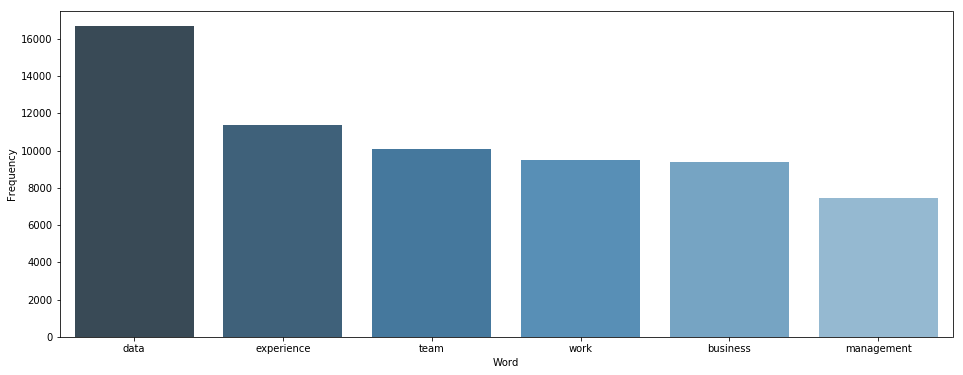

In [102]:
#eliminate stopwords (and, in ...)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords)
#I store the most common 
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
plt.figure(figsize=(16, 6))
ax= sns.barplot(x=rslt.index, y=rslt["Frequency"],  palette="Blues_d")
plt.show()

In [103]:
#I store the most common words in a list
common_words=rslt.index.tolist()
common_words

['data', 'experience', 'team', 'work', 'business', 'management']

### check common words in different "key-words" jobs' ads

In [107]:
# create new columns where I check where each word is in the content
for word in common_words:
    df_wd[word]=df_wd["Content"].str.contains(word, regex=False).astype(int)
df_wd.head()

,Keywords searched,Link,Job title,Date parsed,Company name,Location,Company type,Job rank,Content,ml count,ml yes,data,experience,team,work,business,management
0,Data Scientist,https://www.jobs.ch/en/vacancies/detail/916705...,Leiter Analytik und Qualitätskontrolle (m/w),2019-09-07,Batterman Consulting Basel AG,Muttenz,Consultants,Executive po­si­tion,leiter analytik und qualitätskontrolle (m/w)le...,0,0,0,0,1,0,0,0
1,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918366...,Associate Scientist,2019-09-07,Harvey Nash AG,Basel,Consultants,Employee,associate scientistfor our client in basel we ...,0,0,1,0,1,1,0,1
2,Data Scientist,https://www.jobs.ch/en/vacancies/detail/918778...,Junior Data Analyst (m/w),2019-09-07,Coop Genossenschaft,Basel,Large-scale entreprises,Employee,"coop hat den anspruch, die beste und kundennäc...",0,0,1,0,0,0,0,0
3,Data Scientist,https://www.jobs.ch/en/vacancies/detail/868930...,Senior Data Scientist - Forensics in Zurich,2019-09-07,EY,"Zurich, CH-ZH",Large-scale entreprises,Employee,senior data scientist - forensics in zurichwe ...,2,1,1,1,1,1,0,1
4,Data Scientist,https://www.jobs.ch/en/vacancies/detail/919588...,Data Analyst,2019-09-07,Kelly Scientific Resources Zürich,Graubünden,Consultants,Employee,data analyst unser kunde ist ein unternehmen i...,1,1,1,0,0,0,0,0


### compare distribution inside category

In [115]:
#example for "Data Scientis"
df_wd[common_words][df_wd["Keywords searched"]=="Data Scientist"].sum() / len (df_wd[df_wd["Keywords searched"]=="Data Scientist"])
len (df_wd[df_wd["Keywords searched"]=="Data Scientist"])
df_wd[common_words][df_wd["Keywords searched"]=="Data Scientist"].sum().values


array([439, 322, 395, 358, 236, 227], dtype=int64)

In [117]:
#I do the same things but with all the words

keywords=["Data Scientist", "Data Analyst", "Python Developer", "Data Engineer", "Data Manager", "Data Architect", "Big Data Analyst", "Data Python"]

freq_matrix=np.zeros((len(keywords),len(common_words)))
#freq_matrix

count=0
for key in keywords:

    freq_matrix[count,:]=df_wd[common_words][df_wd["Keywords searched"]==key].sum().values
    freq_matrix[count,:]=freq_matrix[count,:]/len (df_wd[df_wd["Keywords searched"]==key])
    
    count+=1
freq_matrix=np.around(freq_matrix, decimals=2)


### Representation

In [118]:
freq=pd.DataFrame(data=freq_matrix,columns=common_words)
freq.insert(loc=0, column='keywords', value=keywords)
freq

,keywords,data,experience,team,work,business,management
0,Data Scientist,0.99,0.73,0.89,0.81,0.53,0.51
1,Data Analyst,0.98,0.68,0.89,0.80,0.75,0.65
2,Python Developer,0.67,0.83,0.87,0.94,0.46,0.51
3,Data Engineer,0.99,0.68,0.91,0.83,0.54,0.52
4,Data Manager,0.93,0.76,0.88,0.81,0.73,0.76
5,Data Architect,0.98,0.80,0.89,0.86,0.76,0.66
6,Big Data Analyst,0.99,0.53,0.90,0.74,0.67,0.52
7,Data Python,0.99,0.75,0.88,0.84,0.52,0.48


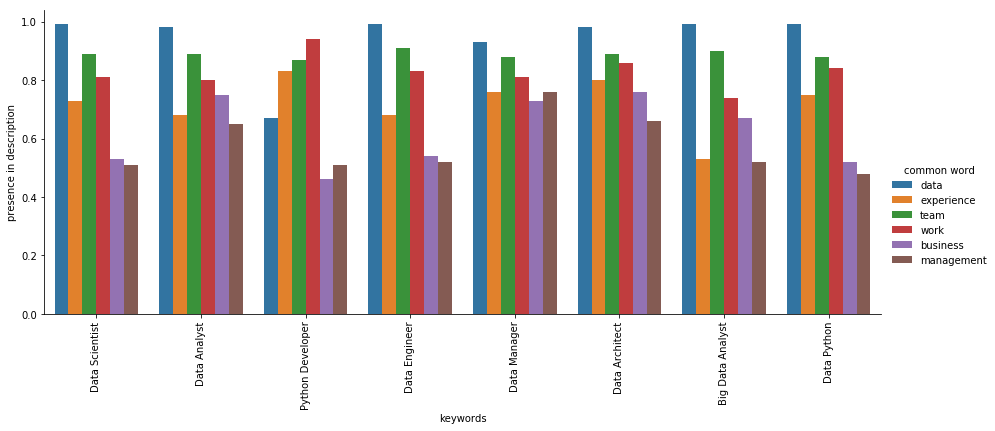

In [119]:
df = pd.melt(freq, id_vars="keywords", var_name="common word", value_name="presence in description")
#df

g=sns.catplot(x='keywords', y='presence in description', hue='common word', data=df, kind='bar', aspect=2.5)
g.set_xticklabels(rotation=90)
None